Initializing library

In [1]:
import pandas as pd
import numpy as np
import pylab as P
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

Read the data into python and clean up the data

In [2]:
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

The variable datetime consist of hour and date of the count. We try to divide data into hourly information (e.g. morning, brunch, lunch, etc...). Second and minute information is useless (since all of them are zeros).

In [3]:
year = np.zeros(len(df))
month = np.zeros(len(df))
date = np.zeros(len(df))
hour = np.zeros(len(df))
minute = np.zeros(len(df))
second = np.zeros(len(df))

for i in range(len(df.datetime)):
    year[i] = df['datetime'][i][0:4]
    month[i] = df['datetime'][i][5:7]
    date[i] = df['datetime'][i][8:10]
    hour[i] = df['datetime'][i][11:13]

df['year'] = year
df['month'] = month
df['date'] = date
df['hour'] = hour

In [4]:
#for the test data
year_test = np.zeros(len(df_test))
month_test = np.zeros(len(df_test))
date_test = np.zeros(len(df_test))
hour_test = np.zeros(len(df_test))
minute_test = np.zeros(len(df_test))
second_test = np.zeros(len(df_test))

for i in range(len(df_test.datetime)):
    year_test[i] = df_test['datetime'][i][0:4]
    month_test[i] = df_test['datetime'][i][5:7]
    date_test[i] = df_test['datetime'][i][8:10]
    hour_test[i] = df_test['datetime'][i][11:13]

df_test['year'] = year_test
df_test['month'] = month_test
df_test['date'] = date_test
df_test['hour'] = hour_test

In [5]:
X = df.drop(['datetime','casual','registered'],axis =1 )
y = X['count'][0::]
y = y.values
X = X.drop(['count'],axis = 1)
X = X.values

In [6]:
# for the test value
X_test = df_test.drop(['datetime'],axis =1 )
X_test = X_test.values

In [7]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,date,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,2011,1,1,4


Data is clean and ready to be trained. We will use the randomforest regressor to first try to train it. Casual and registered is dropped since its not there either in the test set.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

# X_train, X_test, y_train, y_test = train_test_split(X, y)
# X_train.shape, X_test.shape

#testing out the cross val score
print( cross_val_score(RandomForestRegressor(20,max_depth=2), X, y, cv=10) )


[ -7.16208982e+00  -6.07015360e-02   3.71396494e-01   2.84244198e-01
   2.87013229e-01  -6.91695992e-01   3.99716511e-03   3.74267798e-01
   3.16359603e-01   1.50896472e-01]


Plotting the validation curve, define the scoring by rms error, and plot with error bar.

In [9]:
from sklearn.learning_curve import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((np.log(y_pred+1)-np.log(y+1)) ** 2))
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    


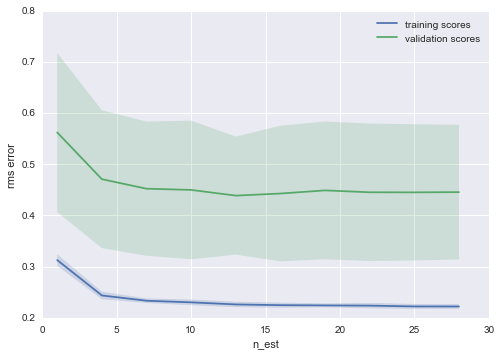

In [17]:
#varying the n_estimators
n_est = range(1,31,3)
val_train, val_test = validation_curve(RandomForestRegressor(max_depth = 12), X, y,
                                       'n_estimators',n_est, cv=10,
                                       scoring=rms_error)
plot_with_err(n_est, val_train, label='training scores')
plot_with_err(n_est, val_test, label='validation scores')
plt.xlabel('n_est'); plt.ylabel('rms error')
plt.legend();

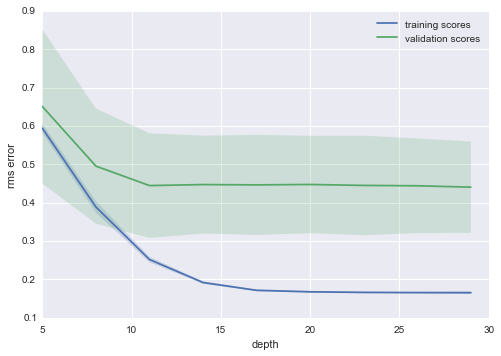

In [11]:
#varying the max_depth
depth = range(5,30,3)
val_train, val_test = validation_curve(RandomForestRegressor(n_estimators = 15), X, y,
                                       'max_depth',depth, cv=10,
                                       scoring=rms_error)
plot_with_err(depth, val_train, label='training scores')
plot_with_err(depth, val_test, label='validation scores')
plt.xlabel('depth'); plt.ylabel('rms error')
plt.legend();

From the first trial of plotting validation curve, it seems like with max_depth ~ 7 to 12, and n_estimators = 15 to 20, the model seems to perform well enough in cross validation data. Now we plot the learning curve.

In [12]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(n_est = 17,depth = 20):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(RandomForestRegressor(n_estimators=n_est,max_depth=depth),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    #plt.ylim(0, 0.1)
    #plt.xlim(5, 80)
    plt.legend()    

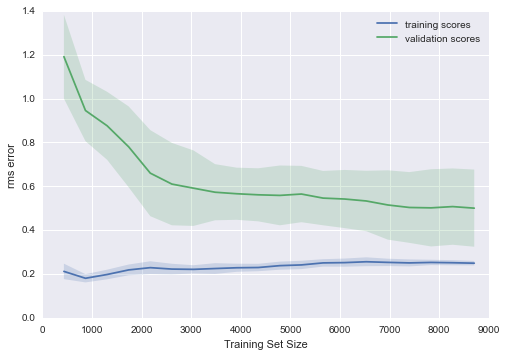

In [21]:
plot_learning_curve(15,11)

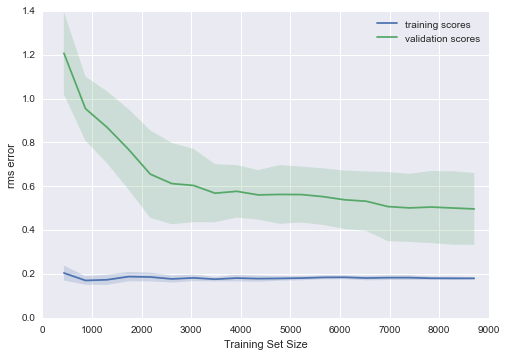

In [19]:
plot_learning_curve(15,15)

Calculating for the test value

In [20]:
y_test = RandomForestRegressor(n_estimators=15,max_depth=15).fit(X,y).predict(X_test)
resultdf = pd.DataFrame(df_test['datetime'])
resultdf['count'] = y_test
resultdf.to_csv('randomforest.csv',index=False)

In [ ]:
df_test.head()

In [ ]:
df.head()

In [ ]:
plt.scatter(range(len(df[0:24])),df['count'][0:24])

In [ ]:
plt.scatter(range(len(df[24:48])),df['count'][24:48])

In [ ]:
df.date[0:20]